In [1]:
import pandas as pd
import numpy as np
import fasttext
import os
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from gensim.utils import simple_preprocess
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# The file is opened using panda library

h = pd.read_csv("Airline-Sentiment-2-w-AA.csv")
h = pd.DataFrame(h,columns=['airline_sentiment','text'])
h

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it
...,...,...
14635,positive,@AmericanAir thank you we got on a different flight to Chicago.
14636,negative,@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc
14637,neutral,@AmericanAir Please bring American Airlines to #BlackBerry10
14638,negative,"@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??"


In [21]:
#looking for null values in the dataset

h.isnull()
#Since that a rating "0" means that the user hasn’t tried the recipe, I deleted that rating.
h = h[h.airline_sentiment != 0]
h.shape

(14640, 2)

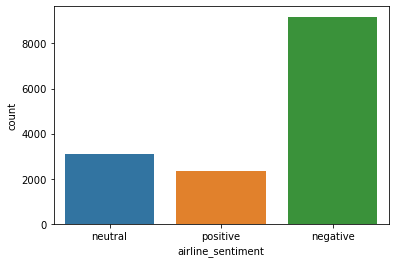

In [4]:
# plotting total ratings and provide an overall feedback

cx = sns.countplot(x="airline_sentiment", data=h)

In [5]:
# pre-proccessing the dataset and take the selected column from the dataset 
rc = pd.DataFrame(h,columns=['airline_sentiment','text'])

#droping null values from the dataset
rc.dropna(subset = ["text"], inplace=True)
rc.dropna(subset = ["airline_sentiment"], inplace=True)
rc.to_csv('airline.csv')

In [6]:
# Importing the dataset and labelling the dataset for fasttext recognition 
dataset = pd.read_csv('airline.csv')[['text', 'airline_sentiment']].rename(columns = {'text': 'texts', 'airline_sentiment': 'airline_sentiments'})
#ds = pd.read_csv('valid.csv')[['Body', 'Y']].rename(columns = {'Body': 'questions', 'Y': 'category'})

# NLP Preprocess is done to provide plain text except any signs and symbols
dataset.iloc[:, 0] = dataset.iloc[:, 0].apply(lambda x: ' '.join(simple_preprocess(x)))


# Prefixing each row of the category column with '__label__' which is necessary for processing and training
dataset.iloc[:, 1] = dataset.iloc[:, 1].apply(lambda x: '__label__' + str(x))

In [7]:
# saving the collected columns into a text file
dataset[['airline_sentiments', 'texts']].to_csv('Airline_Review.txt', 
                                          index = False, 
                                          sep = ' ',
                                          header = None, 
                                          quoting = csv.QUOTE_NONE, 
                                          quotechar = "", 
                                          escapechar = " ")

In [22]:
# Verifing to see if the text is saved properly
!head Airline_Review.txt

__label__neutral virginamerica  what  dhepburn  said
__label__positive virginamerica  plus  you  ve  added  commercials  to  the  experience  tacky
__label__neutral virginamerica  didn  today  must  mean  need  to  take  another  trip
__label__negative virginamerica  it  really  aggressive  to  blast  obnoxious  entertainment  in  your  guests  faces  amp  they  have  little  recourse
__label__negative virginamerica  and  it  really  big  bad  thing  about  it
__label__negative virginamerica  seriously  would  pay  flight  for  seats  that  didn  have  this  playing  it  really  the  only  bad  thing  about  flying  va
__label__positive virginamerica  yes  nearly  every  time  fly  vx  this  ear  worm  won  go  away
__label__neutral virginamerica  really  missed  prime  opportunity  for  men  without  hats  parody  there  https  co  mwpg  grezp
__label__positive virginamerica  well  didn  now  do
__label__positive virginamerica  it  was  amazing  and  arrived  an  hour  early  you  re 

In [8]:
# Separating the text file into .train and .valid file
!head -n 11640 Airline_Review.txt > airline.train
!tail -n 3000 Airline_Review.txt > airline.valid

In [9]:
# Creating a model using airline.train file
model = fasttext.train_supervised(input="airline.train")
model.save_model("model_airline.bin")

In [10]:
# Verifying to see if the training is done properly
model.predict("@VirginAmerica I didn't today... Must mean I need to take another trip!")

(('__label__neutral',), array([0.88354409]))

In [11]:
# Verifying the airline.valid training
model.test("airline.valid")

(3000, 0.8176666666666667, 0.8176666666666667)

In [12]:
# Verifying the rating of 5 tweets
model.test("airline.valid", k=5)

(3000, 0.3333333333333333, 1.0)

In [13]:
# Pre-processing the dataset and pretraining without any symbols or signs
!cat Airline_Review.txt  | sed -e "s/\([.\!?,'/()]\)/ \1 /g" | tr "[:upper:]" "[:lower:]" > Airline_Review.preprocessed.txt
!head -n 11640 Airline_Review.preprocessed.txt > airline_Pre.train
!tail -n 3000 Airline_Review.preprocessed.txt > airline_Pre.valid

In [14]:
# Creating a model using airline_Pre.train file
model = fasttext.train_supervised(input="airline_Pre.train")
model.test("airline_Pre.valid")

(3000, 0.8183333333333334, 0.8183333333333334)

In [15]:
# Creating a model using airline_Pre.valid file while the value of epoch is 25
model = fasttext.train_supervised(input="airline_Pre.train", epoch=25)
model.test("airline_Pre.valid")

(3000, 0.8006666666666666, 0.8006666666666666)

In [16]:
# Creating a model using airline_Pre.valid file while the value of lr is 1
model = fasttext.train_supervised(input="airline_Pre.train", lr=1.0)
model.test("airline_Pre.valid")

(3000, 0.815, 0.815)

In [17]:
# Creating a model using airline_Pre.valid file while the value of epoch is 25 and lr is 1
model = fasttext.train_supervised(input="airline_Pre.train", lr=1.0, epoch=25)
model.test("airline_Pre.valid")

(3000, 0.7733333333333333, 0.7733333333333333)

In [18]:
# Creating a model using airline_Pre.valid file while the value of epoch is 25 and lr is 1 as a Bigram
model = fasttext.train_supervised(input="airline_Pre.train", lr=1.0, epoch=25, wordNgrams=2)
model.test("airline_Pre.valid")

(3000, 0.814, 0.814)

In [19]:
# Validating to see if the model works properly
model.predict("I made the Mexican topping and took it to bunko. Everyone loved it.")

(('__label__positive',), array([0.98288786]))

In [20]:
# Applying multi-label Classification
model = fasttext.train_supervised(input="airline_Pre.train", lr=0.5, epoch=25, wordNgrams=2, bucket=200000, dim=50, loss='ova')
model.test("airline_Pre.valid")
# It is verified that even though it is a multi-label classification it has fair amount of accuracy

(3000, 0.8146666666666667, 0.8146666666666667)